# Pareto Frontier Analisy


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [46]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)', 'classifications correct (percent)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','

    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate,acc'
            pstr = f"{head}\n{pstr}"
            header_printed = True

        return (pstr[:-1])

In [47]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    
    df['inc_rate'] = df['inc_rate'].astype('Int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size', 'instances', 'time', 'delay', 'out_rate', 'acc']]

In [48]:
#loads the csv as a dataframe and standardizes the algorithm names 
def load_df(filename):
    df = pd.read_csv(filename, index_col=False)
    return select_columns_and_rename_values(df)

In [49]:
#standardize algorithm names
def select_columns_and_rename_values(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df["algorithm"].str.replace("OzaBag", "OB")
    df['algorithm'] = df["algorithm"].str.replace("AdaptiveRandomForest", "ARF")
    df['algorithm'] = df["algorithm"].str.replace("SequentialChunk", "SeqMB")
    df['algorithm'] = df["algorithm"].str.replace("OB$", "OBSequential")
    df['algorithm'] = df['algorithm'].str.replace("LeveragingBag", "LBagSequential")
    df['algorithm'] = df['algorithm'].str.replace("Adwin$", "AdwinSequential")
    df['algorithm'] = df['algorithm'].str.replace("CHUNK", "MB")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "MB")
    df['algorithm'] = df['algorithm'].str.replace("StreamingRandomPatches", "SRP")
    df['algorithm'] = df['algorithm'].str.replace("SRP$", "SRPSequential")
    df['algorithm'] = df['algorithm'].str.replace("OBASHT$", "OBASHTSequential")
    df.batch_size.unique()
    return df

In [50]:
#filters by substring (there are multiple OzaBag algorithms)
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

In [51]:
import natsort

#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    if markers:
        colors=['go', 'bs', 'rP', 'md', 'y+' , 'k*']
    else:
        colors=['g', 'b', 'r', 'm', 'y' , 'k']

    labels = df.batch_size
    alg = df.algorithm.unique()[0]
    x = np.arange(len(labels))
    
    ax.plot(x, pd.to_numeric(df.acc), f'{colors[alg_order]}--', linewidth=lwidth, label=f'{alg}-acc')

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylim(50, 100)

In [52]:
#iterates over the parameter configurations and creates the chart grid
def gen_chart(df, markers=True, tables=False):
    datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
    
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    algorithms = ['ARF', 'LBag', 'SRP', 'OBAdwin', 'OBASHT', 'OB']
    
    #creates a 2x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(2, 2, figsize=(12,12), sharey='row')
    filename = "batch-size-vs-prediction-mark" if markers else "batch-size-vs-prediction"

    #each chart presents the results for a given dataset and contains the series for all algorithms
    for ds in datasets:
        title = ''
        my_id = datasets.index(ds)

        #selects the correct position in the grid
        ax = axs[int(my_id/2)][my_id%2]
        ax.set_title(f'{dsformalname[ds]}')

        #for each algorithm
        for alg in algorithms:
            df_aux = filter_by_substring_algorithm(df[df.dataset == ds], alg)
            gen_lines(df_aux, ax, algorithms.index(alg), markers)

            #if its the first column, print Y-axis label
            if my_id%2 == 0:
                ax.set_ylabel('Percentage')
            #if its the last row, print the X-axis label
            if int(my_id/2) == 1:
                ax.set_xlabel('Algorithm Methodology')

    #retrieves the handles and labels to create a global legend
    handles, labels = axs[0][0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(len(algorithms)/2), bbox_to_anchor=(0.5,-0.1))
    fig.tight_layout()
    plt.savefig(f'figures/{filename}.png')
    plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [53]:
resultsFolder = f"../../results/coletor-energia/mini-batching-mediumbatches/first/600/1200"
csvFile = f"../../parsed_csvs/medium-batches.csv"
directory = os.fsencode(resultsFolder)
header_printed = False

with open(f"{csvFile}", "w+") as output:
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.startswith("dump-"): 
            output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")

df = load_df(f'{csvFile}')

# Read Energy Data

In [54]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [55]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                if algorithm not in d:
                    d[algorithm] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [56]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                if type(ed) is str or type(st) is str:
                                    print(ed)
                                    print(st)
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [57]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 
               'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

In [58]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:

            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
                    spline = line.split('-')

                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, bsize, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
                    # d['methodology'].append(methodology.strip())
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False

    print(len(d['algorithm'][0]))
    print(len(d['dataset']))
    print(len(d['inc_rate']))
    print(len(d['batch_size']))
    adf = pd.DataFrame(data=d)
    print
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'Int64'})

In [59]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [60]:
def rename_columns_by_rate(df):
    rate = df.PERC.iloc[0]
    return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})


In [61]:
def read_data_create_final_dataframe(freq, DEBUG=False, times='first'):
    d = {}
    global header_printed
    header_printed = False
    # folder_path = f"{PATH_TO_RESULTS}{times}/{freq['minimum']}/{freq['maximum']}"
    folder_path = f"../../results/pareto/pareto"
    # min = freq['minimum']
    # max = freq['maximum']
    moaDF = read_MOA(f"{folder_path}", f"{folder_path}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay", "acc"]]
    measureDF = load_Wmeas(f'{folder_path}/Wm-log.log')
    # d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-{max}-freq-min-{min}.log', d)
    # d = exper_order_to_dict(f'{folder_path}/exper_order-freq-max-1200-freq-min-600.log', d)
    d = exper_order_to_dict(f'{folder_path}/exper_order.log', d)
    d = populate_dict(d, measureDF)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d, True)
    sshDF = parse_SSH(f'{folder_path}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')

    #join dfs
    finaldf = moaDF.merge(mdf, on=[ 'algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])

    finaldf['avg_times_duration'] = finaldf['avg_measure'] * finaldf['duration']
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPIold'] = finaldf['avg_measure'] / finaldf['instances']
    finaldf['JPI'] = finaldf['avg_times_duration'] / finaldf['instances']
    
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)

    tdf['PERC'] = 0

    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    
    tdf.loc[masks['90'], 'PERC'] = '90'
    tdf.loc[masks['50'], 'PERC'] = '50'
    tdf.loc[masks['10'], 'PERC'] = '10'
    
    tdf['tput'] = tdf['instances'] / tdf['time']
    if DEBUG:
        tdf.to_csv(f"../../results/pareto/pareto/tdf.csv")    
    return tdf

In [62]:
#standardize algorithm names
def select_columns_and_rename_values_basic(df):
    df.algorithm = df.algorithm.str.replace("Executor", "")
    df['algorithm'] = df['algorithm'].str.replace("MAXChunk", "")
    df.batch_size.unique()
    return df

In [63]:
dataframes = []
dataframes.append(read_data_create_final_dataframe("", True))

df = dataframes[0]
df.to_csv('../../results/pareto/pareto/pareto-energy.csv')

print(f'\n\n\n----------------- Energy Consume -----------------')

df = select_columns_and_rename_values_basic(df)
df = df.reset_index()
display(df)

36
432
432
432
moaDF: 432    mdf: 432     sshDF: 432



----------------- Energy Consume -----------------


/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_97953/827218054.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '90' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  tdf.loc[masks['90'], 'PERC'] = '90'


,index,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
0,411,StreamingRandomPatches,elecNormNew,4,2000,467,419.88,"42,000.00",100.03,"4,545.00",...,5.60,"1,058.20",463.09,"45,312.00",582.29,560.06,0.00,0.01,90,419.88
1,212,StreamingRandomPatches,elecNormNew,4,2000,259,244.57,"30,000.00",122.66,"6,918.00",...,4.51,"1,038.20",254.47,"30,549.00",573.27,553.69,0.00,0.02,50,244.57
2,179,StreamingRandomPatches,elecNormNew,4,2000,51,48.81,"6,000.00",122.94,"25,319.00",...,3.43,793.20,49.92,"6,000.00",436.09,422.13,0.00,0.07,10,48.81
3,290,StreamingRandomPatches,elecNormNew,4,500,445,435.97,"44,500.00",102.07,"1,107.00",...,5.68,"1,090.30",443.11,"45,312.00",601.94,579.63,0.00,0.01,90,435.97
4,288,StreamingRandomPatches,elecNormNew,4,500,247,241.95,"29,000.00",119.86,"1,752.00",...,4.54,"1,017.30",244.49,"29,351.00",558.61,544.34,0.00,0.02,50,241.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,423,AdaptiveRandomForest,GMSC,4,50,849,833.93,"100,200.00",120.15,48.00,...,5.71,"1,295.60",842.29,"101,231.00",713.44,685.78,0.00,0.01,50,833.93
428,152,AdaptiveRandomForest,GMSC,4,50,169,164.81,"19,750.00",119.83,183.00,...,4.60,"1,026.90",164.72,"19,767.00",566.41,551.83,0.00,0.03,10,164.81
429,243,AdaptiveRandomForest,GMSC,4,25,1417,"1,383.65","149,725.00",108.21,17.00,...,6.41,"1,302.20","1,407.26","150,000.00",718.46,694.14,0.00,0.00,90,"1,383.65"
430,390,AdaptiveRandomForest,GMSC,4,25,787,782.47,"93,900.00",120.00,24.00,...,5.51,"1,251.60",782.57,"94,043.00",689.21,661.67,0.00,0.01,50,782.47


In [64]:
#plots precision and recall with markers of one parameter configuration
def gen_lines(df, ax, alg_order, markers):
    lwidth = 0.75
    colors=['g', 'b', 'r', 'm', 'y' , 'k']
    batchs = [25, 50, 100, 250, 500, 2000]

    df['time_in_s'] = (df['time'] / 60).round(2).astype(str)
    # df['IPS'] = df['instances'] / df['time']

    for batch in batchs:
        id_batch = batchs.index(batch)
        df_batch = df[df.batch_size == batch]

        x = df_batch['JPI']
        y = df_batch['delay']

        ax.scatter(x, y, c=colors[id_batch], label=f"{batch}")

    # y_ticks = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Valores de exemplo, ajuste conforme necessário
    # ax.set_yticks(y_ticks)

/var/folders/gp/z_8fmvzj0j56pwsmjhy5zrph0000gp/T/ipykernel_97953/2544620644.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 3, figsize=(9, 4), sharey='row')


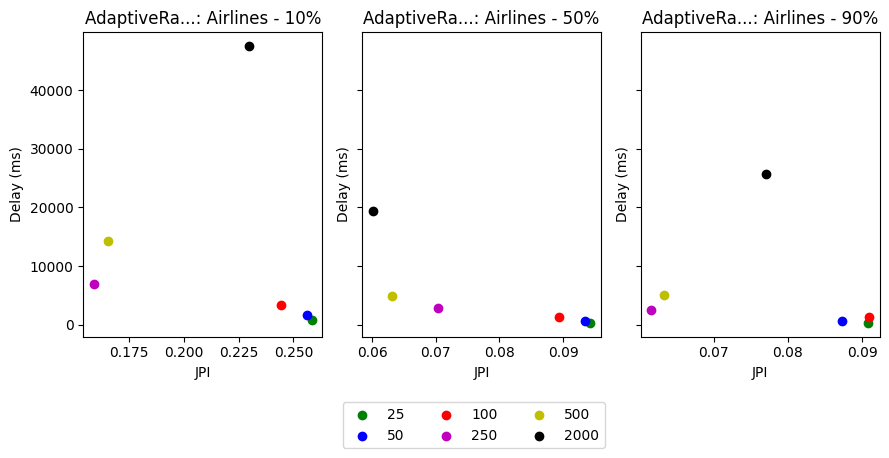

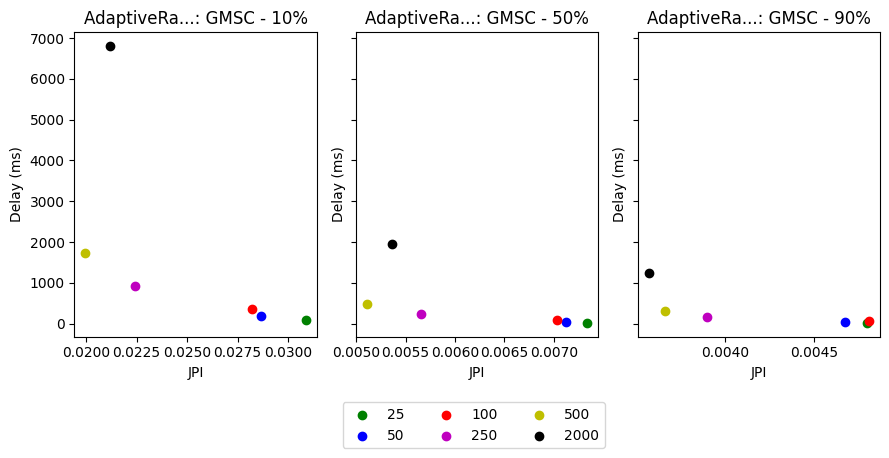

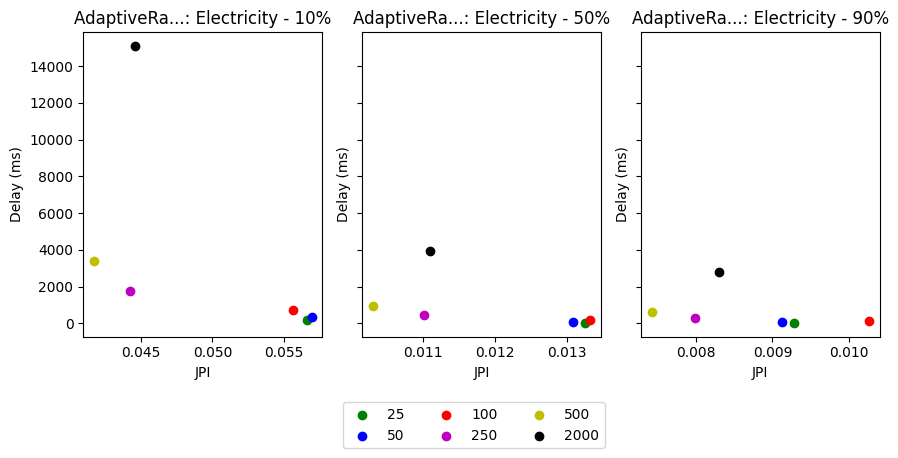

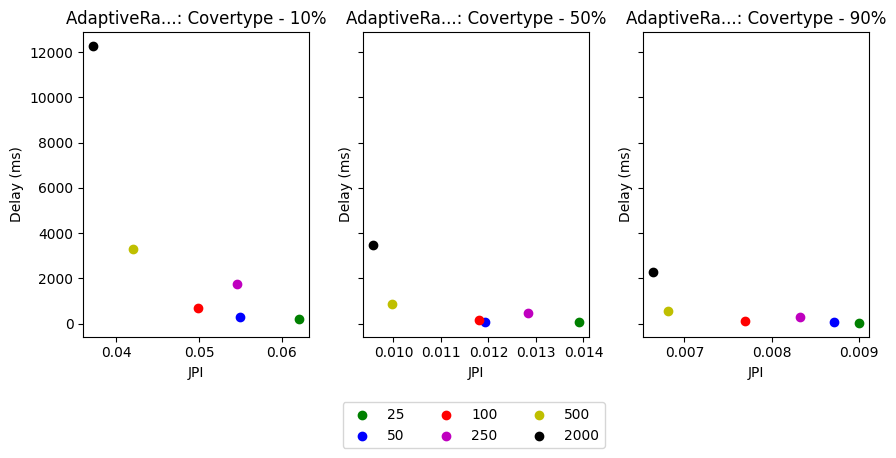

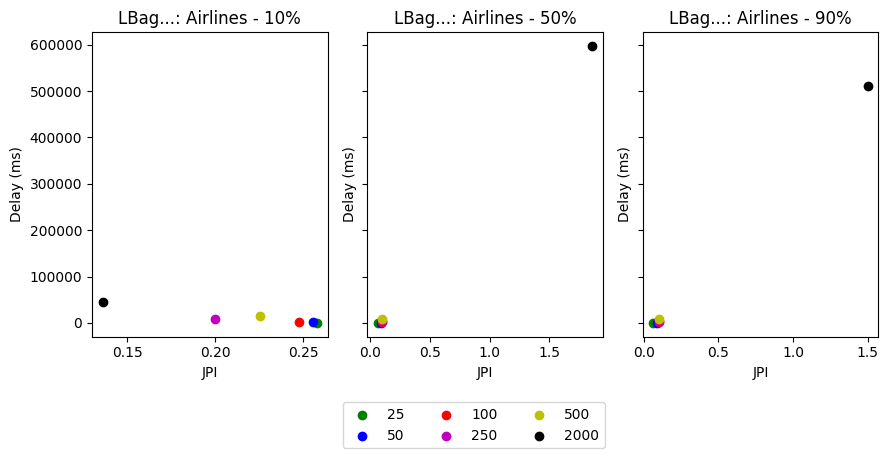

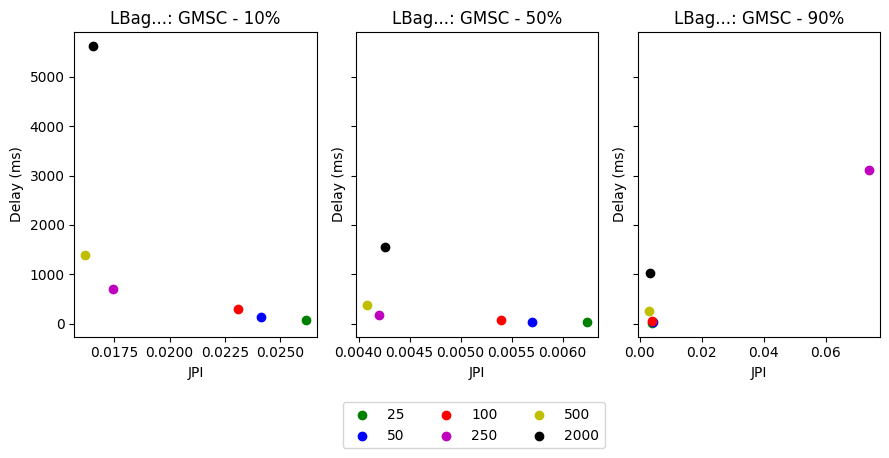

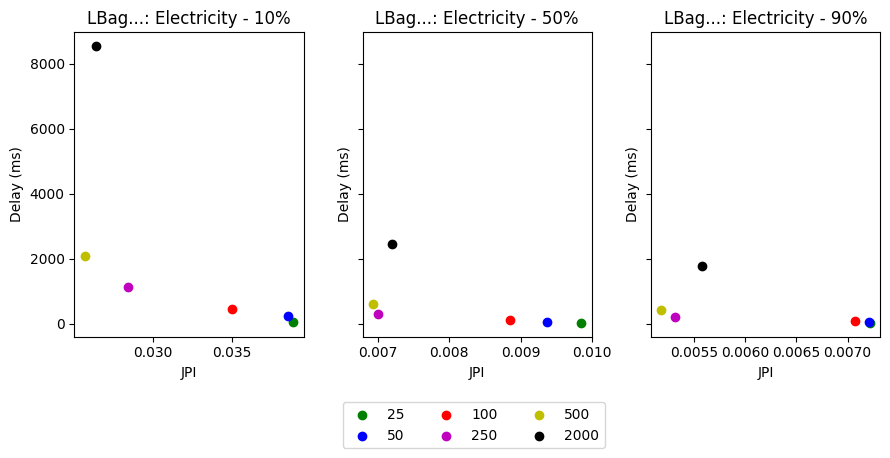

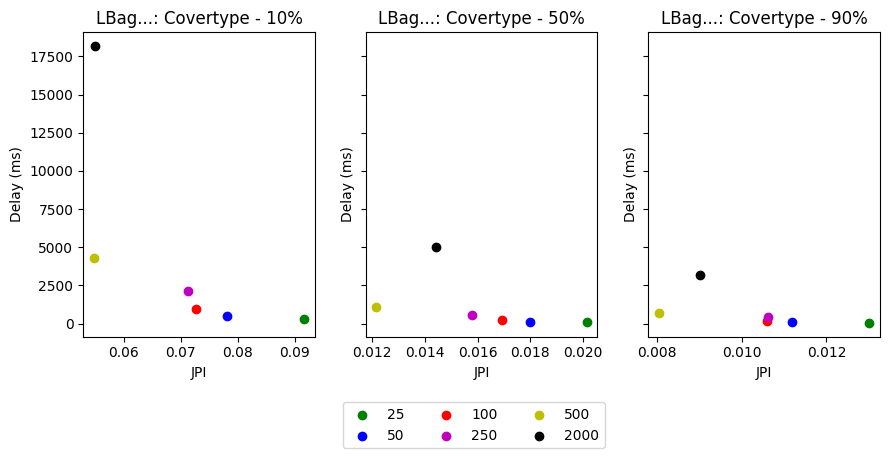

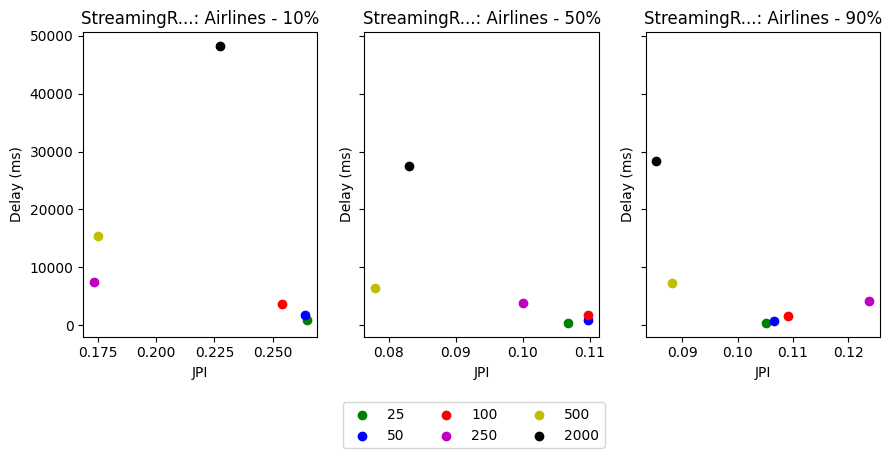

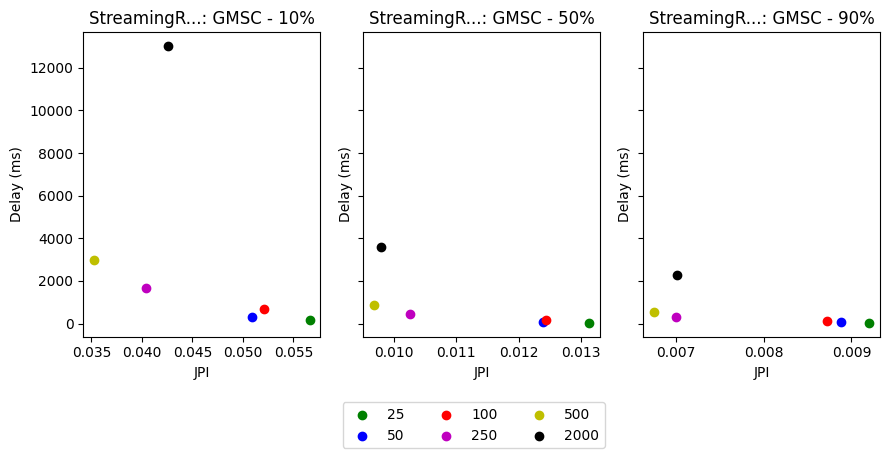

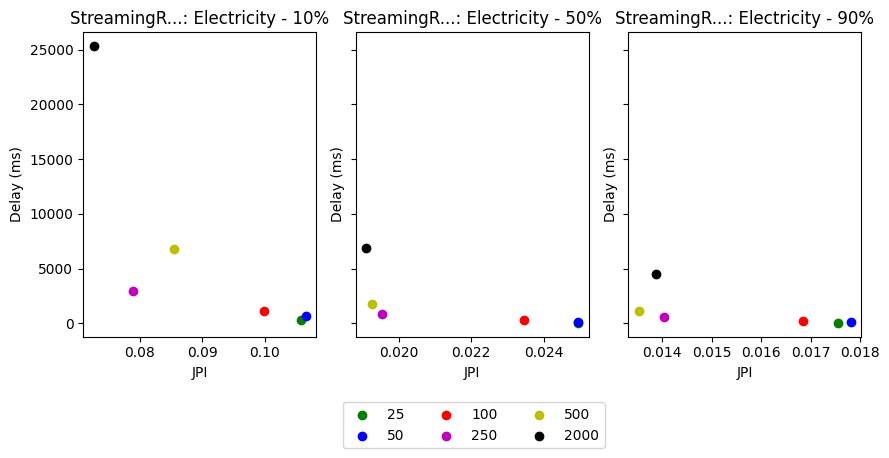

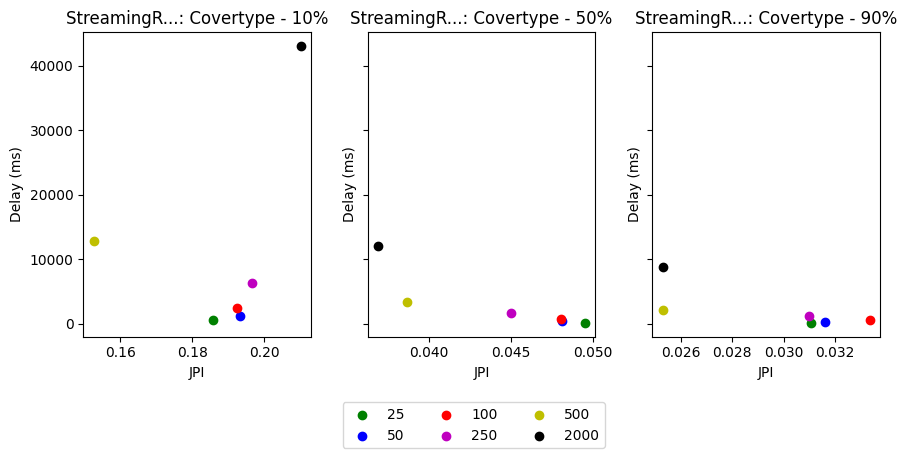

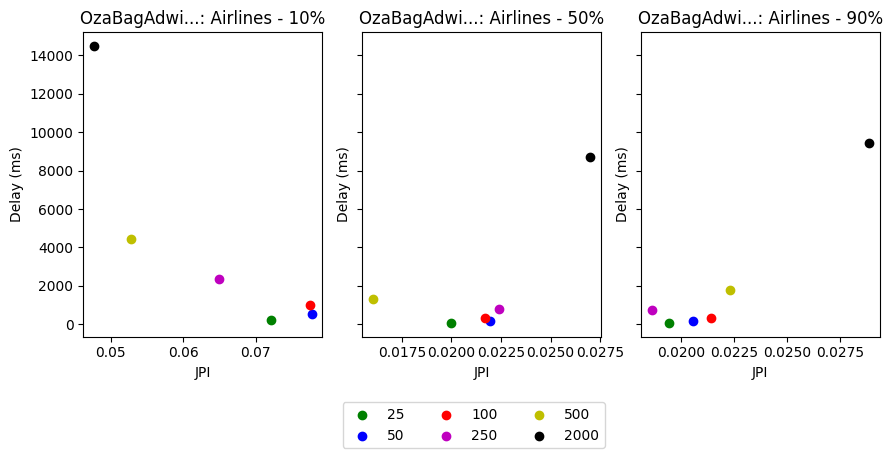

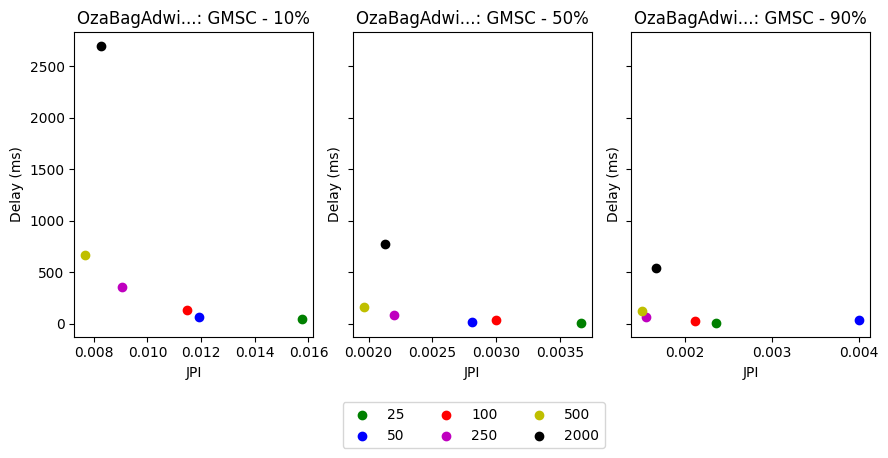

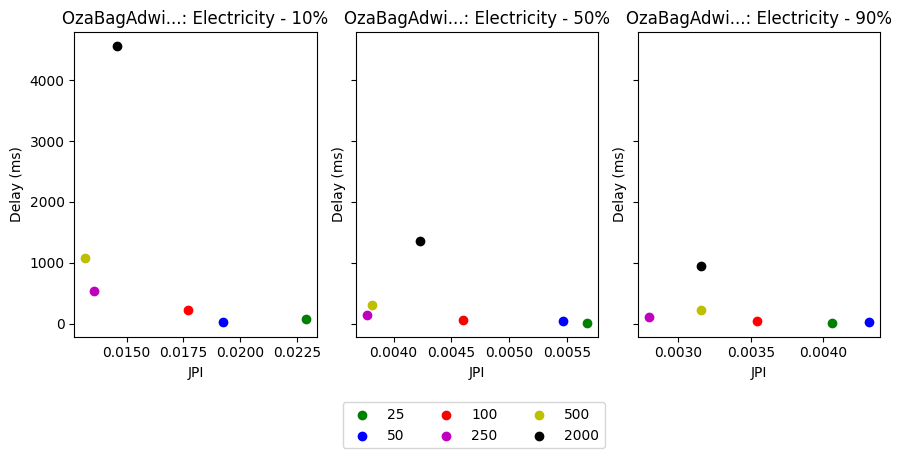

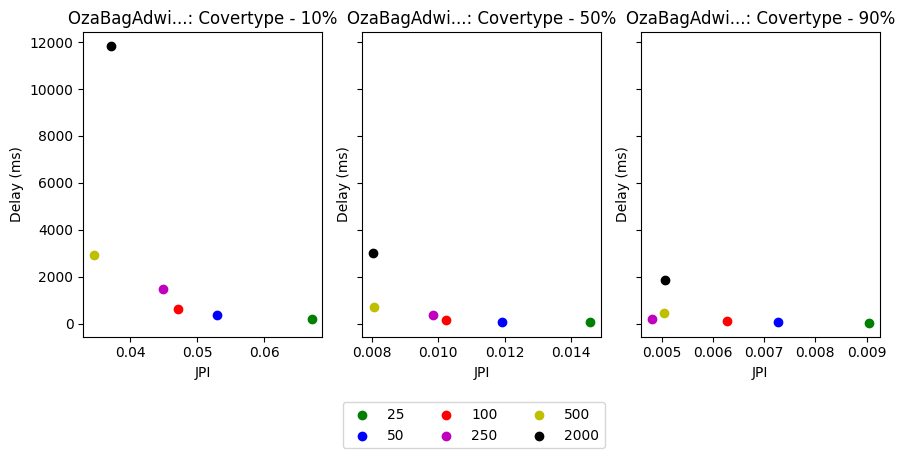

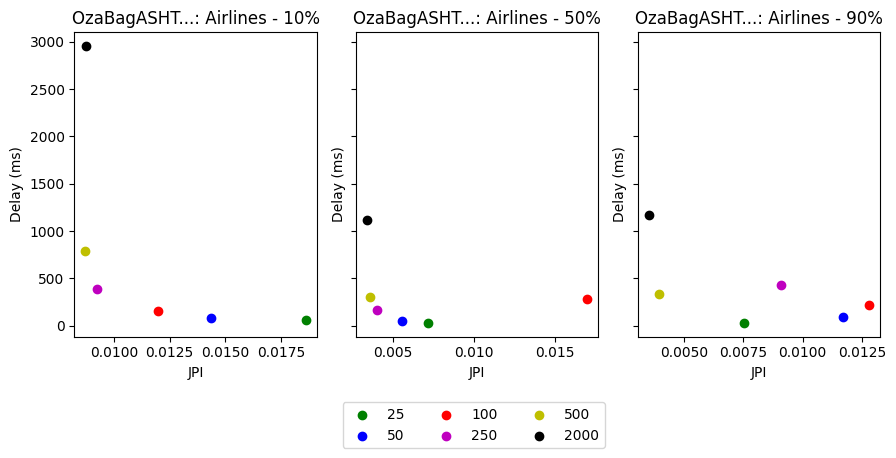

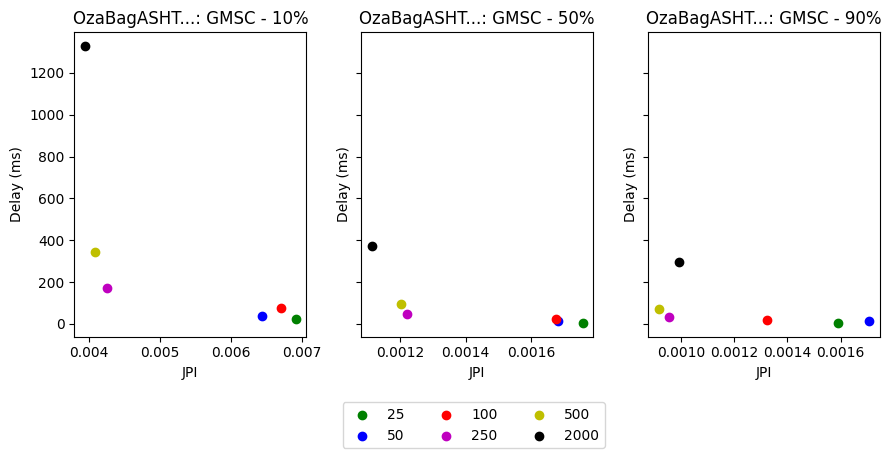

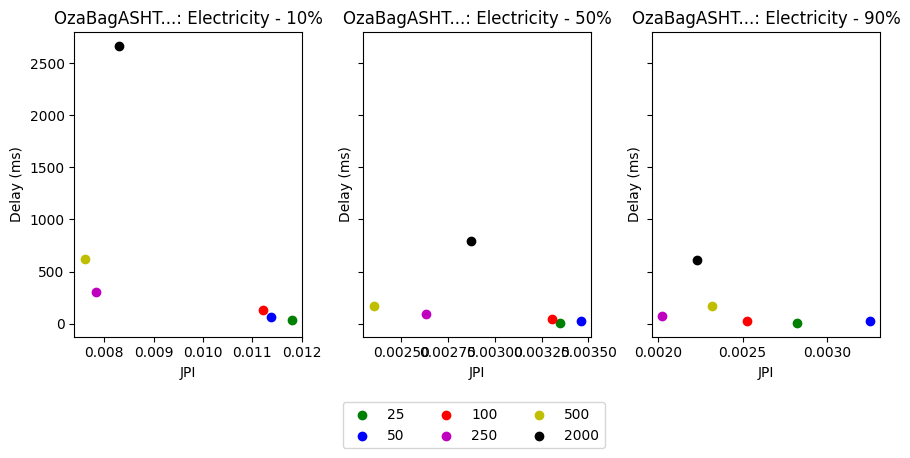

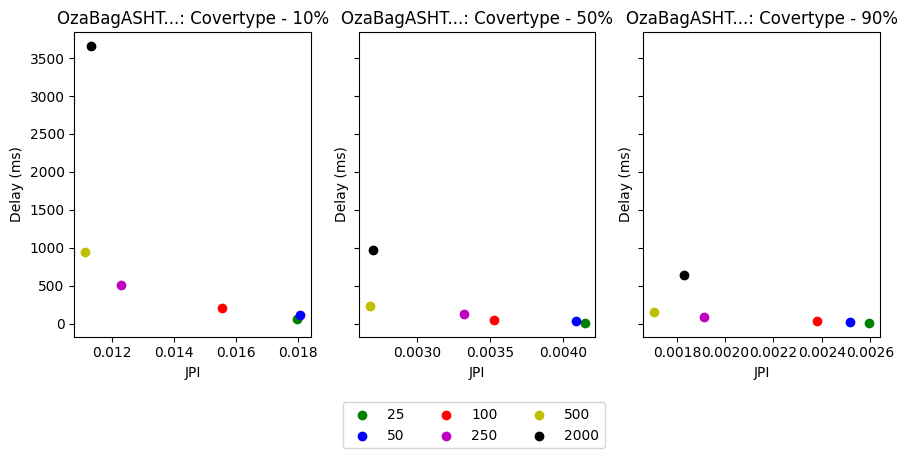

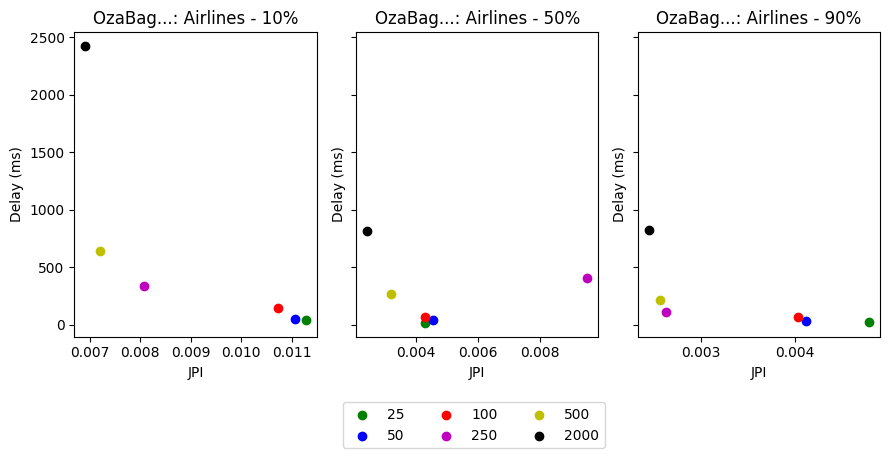

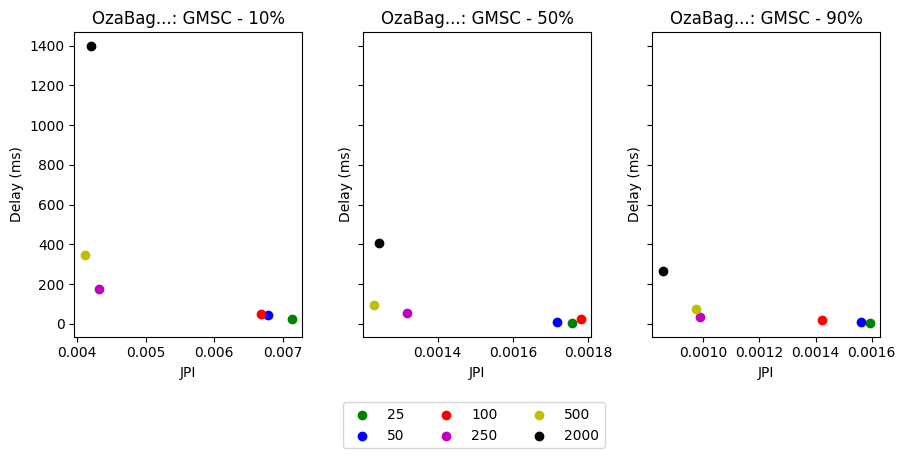

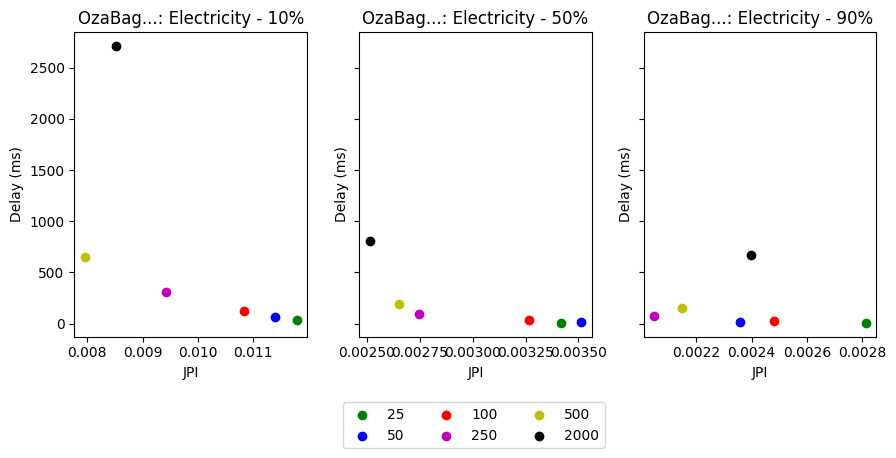

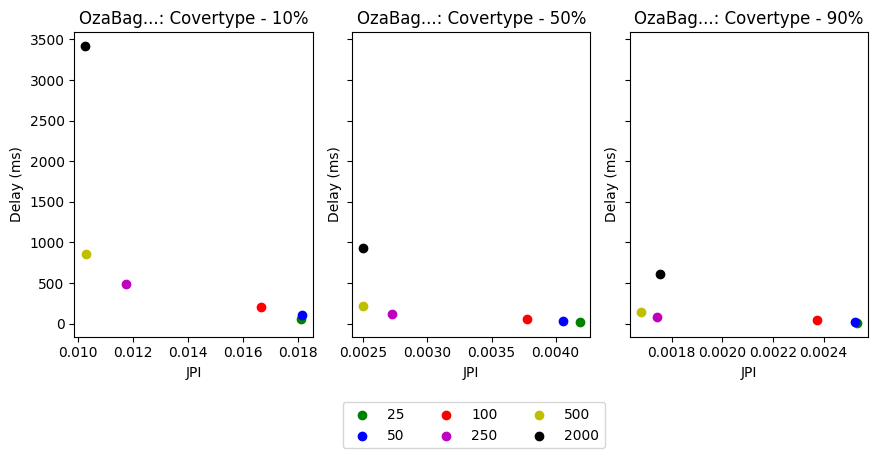

In [65]:
def gen_chart(df, datasets, algorithms, markers=True):
    percs = ['10', '50', '90']
    
    #dictionary containing the correct name to be printed
    dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
    
    #creates a 1x2 grid for plotting the charts
    #sharey=row means that all charts in a row share the same Y-axis
    fig, axs = plt.subplots(1, 3, figsize=(9, 4), sharey='row')

    for perc in percs:
        my_id_perc = percs.index(perc)
        
        for ds in datasets:
            title = ''
            my_id = datasets.index(ds)
            
            #for each algorithm
            for alg in algorithms:
                df_aux = df[df.PERC == perc]
                df_aux = filter_by_substring_algorithm(df_aux[df_aux.dataset == ds].sort_values(by=['JPI']), alg)

                ax = axs[my_id_perc]
                ax.set_title(f'{alg[:10]}...: {dsformalname[ds]} - {perc}%')

                gen_lines(df_aux, ax, percs.index(perc), markers)

                if my_id%2 == 0:
                    ax.set_ylabel('Delay (ms)')

                ax.set_xlabel('JPI')

    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc = 'lower center', ncol = math.ceil(3), bbox_to_anchor=(0.532,-0.15))
    fig.tight_layout()

    # plt.savefig(f'figures/{filename}.png')
    # plt.savefig(f'figures/{filename}.eps', bbox_extra_artists=(lgd,), bbox_inches='tight')

for alg in ['AdaptiveRandomForest', 'LBag', 'StreamingRandomPatches', 'OzaBagAdwin', 'OzaBagASHT', 'OzaBag']:
    for ds in ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']:
        gen_chart(df, [ds], [alg])

## Pareto por Porcentagem

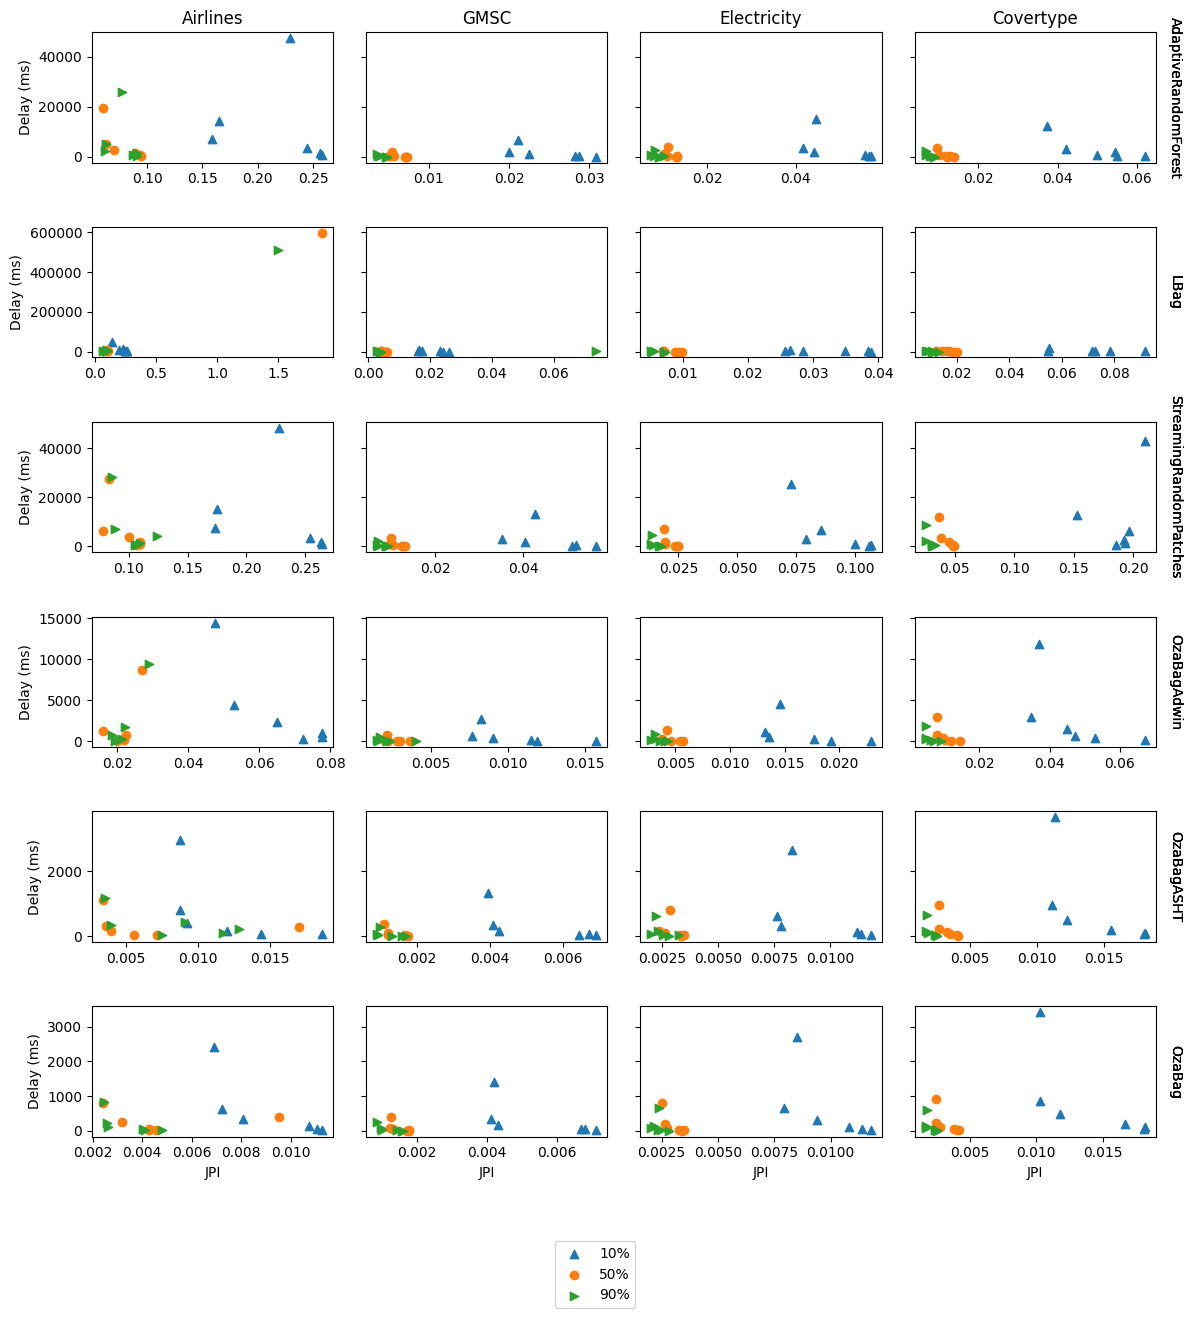

In [66]:

datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
algorithms = ['AdaptiveRandomForest', 'LBag', 'StreamingRandomPatches', 'OzaBagAdwin', 'OzaBagASHT', 'OzaBag']
plots = [
    {
        'color': 'tab:blue',
        'perc': '10',
        'label': '10% Vazão',
        'marker': '^'
    },
    {
        'color': 'tab:orange',
        'perc': '50',
        'label': '50% Vazão',
        'marker': 'o'
    },
    {
        'color': 'tab:green',
        'perc': '90',
        'label': '90% Vazão',
        'marker': '>'
    }
]

fig, axs = plt.subplots(6, 4, figsize=(12, 12), sharey='row')

# Loop para criar os gráficos
for color in plots:
    df_aux_perc = df[df.PERC == color['perc']]

    for ds in datasets:
        my_id = datasets.index(ds)

        # Seleciona a posição correta na grade
        ax = axs[int(my_id/4)][my_id%4]
        ax.set_title(f'{dsformalname[ds]}')

        for alg in algorithms:
            my_id_alg = algorithms.index(alg)
            df_aux = df_aux_perc[df_aux_perc.dataset == ds]
            df_aux = df_aux[df_aux.algorithm == alg]

            df_aux['time_in_m'] = (df_aux['time'] / 60).round(2).astype(str)

            x = df_aux['JPI']
            y = df_aux['delay']

            ax = axs[int(my_id_alg)][int(my_id)]

            # Define os intervalos dos valores exibidos no eixo y
            # y_ticks = [0, 10, 20, 30, 40]  # Valores de exemplo, ajuste conforme necessário
            # ax.set_yticks(y_ticks)

            ax.scatter(x, y, c=color['color'], marker=color['marker'], label=f"{color['perc']}%")

            if (my_id == 3):
                ax.text(1.05, 0.5, alg, transform=ax.transAxes, rotation=-90, va='center')


# Adiciona legendas aos eixos x e y
for ax in axs[-1]:
    ax.set_xlabel('JPI')
for ax in axs[:, 0]:
    ax.set_ylabel('Delay (ms)')

# Exibe a legenda
handles, labels = axs[0][0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol=math.ceil(len(algorithms)/6), bbox_to_anchor=(0.5,-0.1))
fig.tight_layout()

# Exibe o gráfico
plt.show()


### Pareto Por Tamanho do Batch

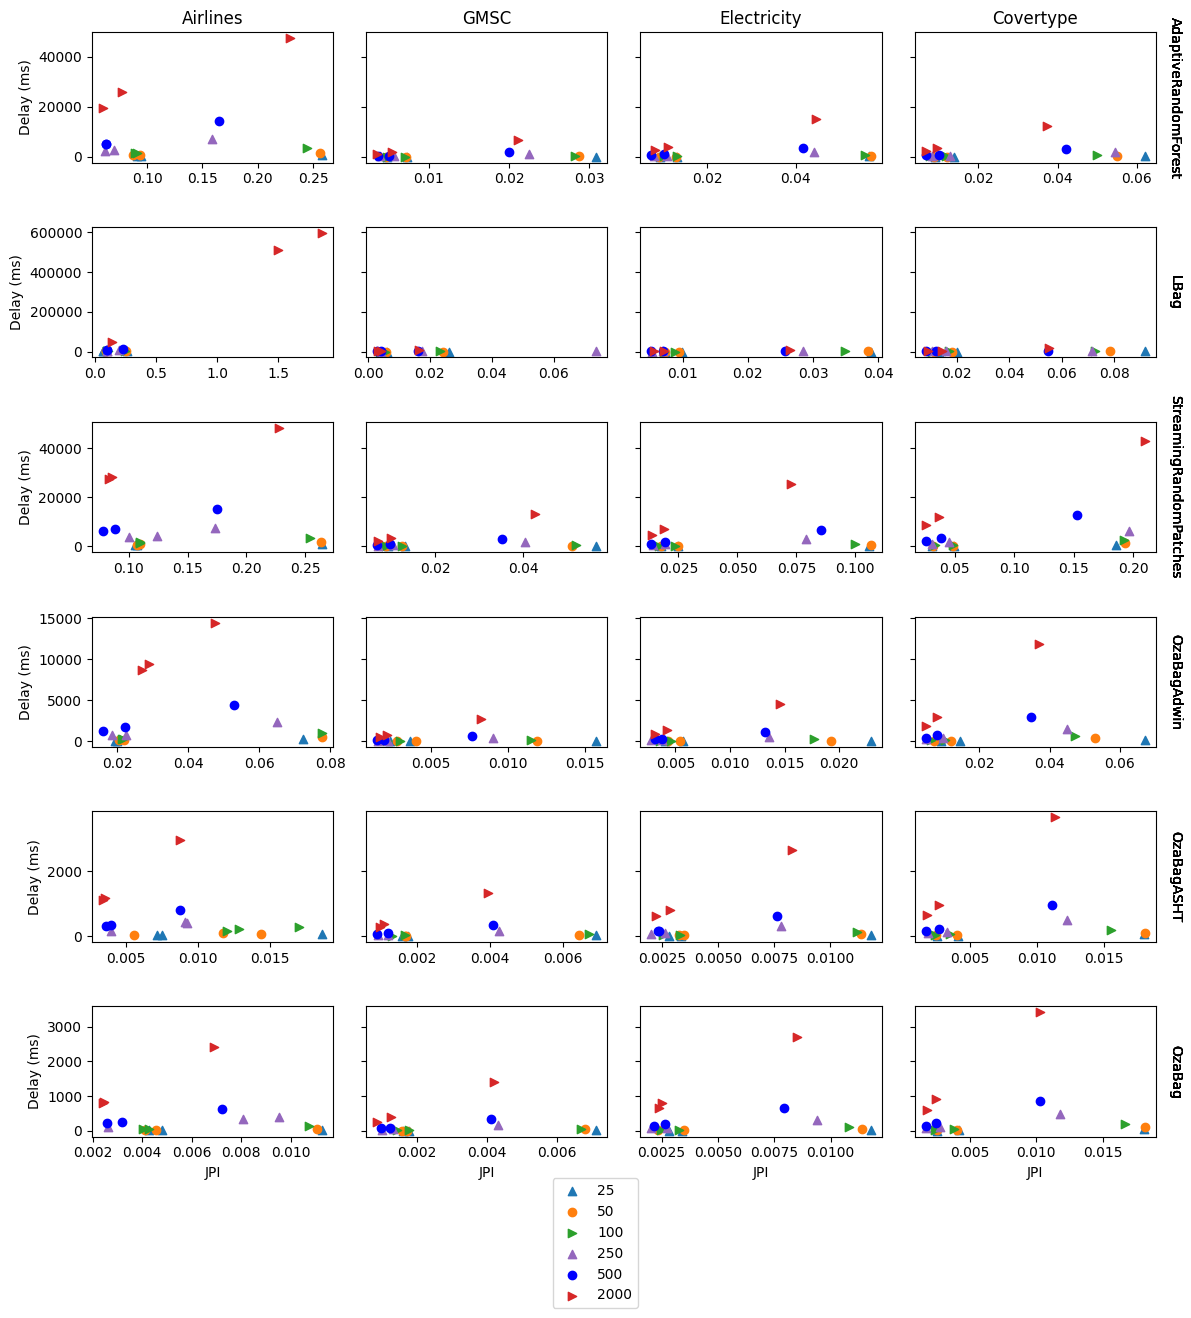

In [67]:

datasets = ['airlines', 'GMSC', 'elecNormNew', 'covtypeNorm']
dsformalname = {'elecNormNew': 'Electricity', 'GMSC': 'GMSC', 'airlines': 'Airlines', 'covtypeNorm': 'Covertype'}
algorithms = ['AdaptiveRandomForest', 'LBag', 'StreamingRandomPatches', 'OzaBagAdwin', 'OzaBagASHT', 'OzaBag']

plots = [
    {
        'color': 'tab:blue',
        'batch': 25,
        'label': '25',
        'marker': '^'
    },
    {
        'color': 'tab:orange',
        'batch': 50,
        'label': '50',
        'marker': 'o'
    },
    {
        'color': 'tab:green',
        'batch': 100,
        'label': '100',
        'marker': '>'
    },
    {
        'color': 'tab:purple',
        'batch': 250,
        'label': '250',
        'marker': '^'
    },
    {
        'color': 'b',
        'batch': 500,
        'label': '500',
        'marker': 'o'
    },
    {
        'color': 'tab:red',
        'batch': 2000,
        'label': '2000',
        'marker': '>'
    }
]

fig, axs = plt.subplots(6, 4, figsize=(12, 12), sharey='row')

# Loop para criar os gráficos
for color in plots:
    df_aux_batch = df[df.batch_size == color['batch']]

    for ds in datasets:
        my_id = datasets.index(ds)

        # Seleciona a posição correta na grade
        ax = axs[int(my_id/4)][my_id%4]
        ax.set_title(f'{dsformalname[ds]}')

        for alg in algorithms:
            my_id_alg = algorithms.index(alg)
            df_aux = df_aux_batch[df_aux_batch.dataset == ds]
            df_aux = df_aux[df_aux.algorithm == alg]

            df_aux['time_in_m'] = (df_aux['time'] / 60).round(2).astype(str)

            x = df_aux['JPI']
            y = df_aux['delay']

            ax = axs[int(my_id_alg)][int(my_id)]

            # Define os intervalos dos valores exibidos no eixo y
            # y_ticks = [0, 10, 20, 30, 40]  # Valores de exemplo, ajuste conforme necessário
            # ax.set_yticks(y_ticks)

            ax.scatter(x, y, c=color['color'], marker=color['marker'], label=f"{color['batch']}")

            if (my_id == 3):
                ax.text(1.05, 0.5, alg, transform=ax.transAxes, rotation=-90, va='center')


# Adiciona legendas aos eixos x e y
for ax in axs[-1]:
    ax.set_xlabel('JPI')
for ax in axs[:, 0]:
    ax.set_ylabel('Delay (ms)')

# Exibe a legenda
handles, labels = axs[0][0].get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='lower center', ncol=math.ceil(len(algorithms)/6), bbox_to_anchor=(0.5,-0.1))
fig.tight_layout()

# Exibe o gráfico
plt.show()


In [ ]:
# Processing Pareto

df_airlines = df[df.dataset == 'elecNormNew']
df_airlines = df_airlines[df_airlines.algorithm == 'StreamingRandomPatches']
df_airlines['PERC'] = pd.to_numeric(df_airlines['PERC'])

df_par = df_airlines
# display(df_par)
# df_par.columns = ['PERC']

# df_par.sort_values(['JPI'], ascending = False, inplace = True)
# df_par.reset_index(inplace = True)

# # Cumulative Sum 
# df_par['CumSum'] = df_par['JPI'].cumsum()

# # % CumSum
# df_par['%CumSum'] = (100 * df_par['CumSum'] / df_par['JPI'].sum())

# df_par['%batch_size'] = (100 * (df_par.index + 1).astype(float)/(df_par.index.max() + 1))

df_par90 = df_par[df_par['PERC'] == 90].copy()
perc_batch90 = df_par[df_par['PERC'] == 90]['JPI'].min()
perc_sum90 = df_par[df_par['PERC'] == 90]['JPI'].min()

df_batch50 = df_par[df_par['PERC'] == 50].copy()
perc_batch50 = df_batch50['JPI'].min()
perc_sum50 = df_batch50['JPI'].min()

df_batch10 = df_par[df_par['PERC'] == 10].copy()
perc_batch10 = df_par[df_par['PERC'] == 10]['JPI'].min()
perc_sum10 = df_par[df_par['PERC'] == 10]['JPI'].min()

# print("Pareto Analysis for {:,} unique SKU".format(len(df_par)))
df_par.head(200)

,index,algorithm,dataset,cores,batch_size,inc_rate,out_rate,instances,time,delay,...,avg_measure,sum_measure,prod_rate,tt_inst_prod,avg_times_duration,joules,JPIold,JPI,PERC,tput
0,411,StreamingRandomPatches,elecNormNew,4,2000,467,419.88,"42,000.00",100.03,"4,545.00",...,5.60,"1,058.20",463.09,"45,312.00",582.29,560.06,0.00,0.01,90,419.88
1,212,StreamingRandomPatches,elecNormNew,4,2000,259,244.57,"30,000.00",122.66,"6,918.00",...,4.51,"1,038.20",254.47,"30,549.00",573.27,553.69,0.00,0.02,50,244.57
2,179,StreamingRandomPatches,elecNormNew,4,2000,51,48.81,"6,000.00",122.94,"25,319.00",...,3.43,793.20,49.92,"6,000.00",436.09,422.13,0.00,0.07,10,48.81
3,290,StreamingRandomPatches,elecNormNew,4,500,445,435.97,"44,500.00",102.07,"1,107.00",...,5.68,"1,090.30",443.11,"45,312.00",601.94,579.63,0.00,0.01,90,435.97
4,288,StreamingRandomPatches,elecNormNew,4,500,247,241.95,"29,000.00",119.86,"1,752.00",...,4.54,"1,017.30",244.49,"29,351.00",558.61,544.34,0.00,0.02,50,241.95
5,196,StreamingRandomPatches,elecNormNew,4,500,49,41.67,"5,000.00",119.99,"6,787.00",...,3.45,775.30,44.93,"5,400.00",427.28,413.45,0.00,0.09,10,41.67
6,9,StreamingRandomPatches,elecNormNew,4,250,460,447.78,"44,250.00",98.82,549.00,...,6.03,"1,128.20",458.41,"45,312.00",621.41,596.20,0.00,0.01,90,447.78
7,251,StreamingRandomPatches,elecNormNew,4,250,256,253.45,"30,500.00",120.34,868.00,...,4.80,"1,080.90",254.48,"30,549.00",595.70,578.11,0.00,0.02,50,253.45
8,362,StreamingRandomPatches,elecNormNew,4,250,51,49.85,"6,000.00",120.36,"2,980.00",...,3.79,861.00,49.92,"6,000.00",474.12,456.52,0.00,0.08,10,49.85
9,201,StreamingRandomPatches,elecNormNew,4,100,462,429.66,"43,900.00",102.17,232.00,...,6.91,"1,347.50",458.33,"45,312.00",739.40,706.04,0.00,0.02,90,429.66


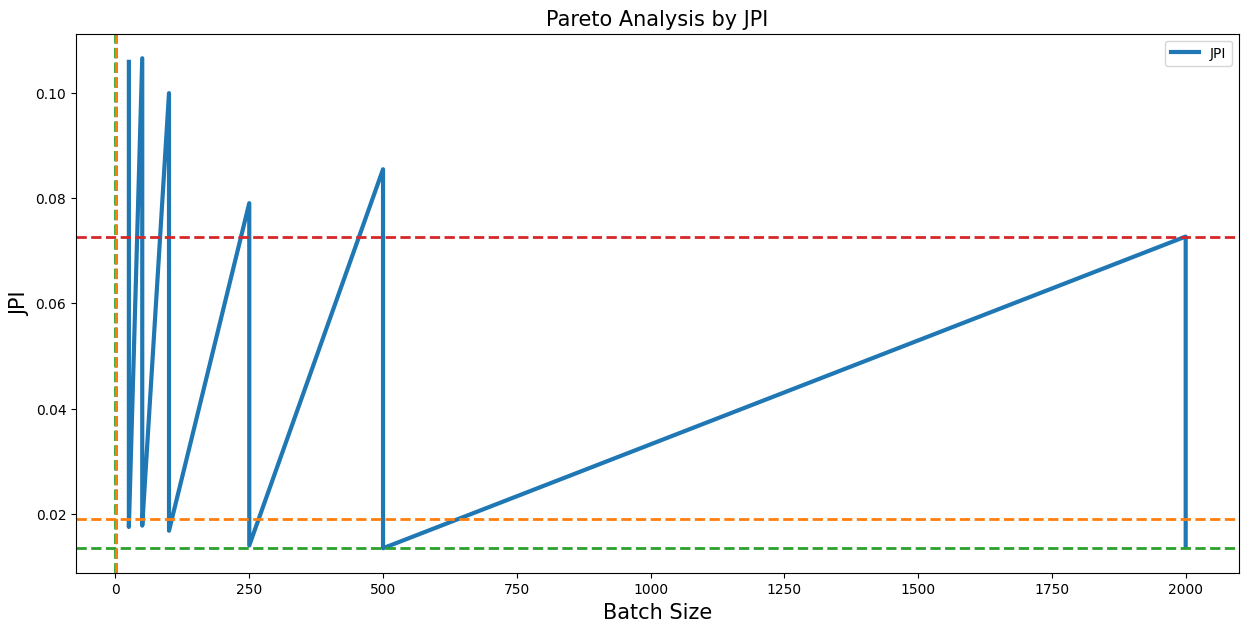

In [ ]:
ax = df_par.plot(x='batch_size', y='JPI', figsize = (15,7), color = 'tab:blue', legend = True, linewidth=3)
plt.xlabel('Batch Size',fontsize=15)
plt.ylabel('JPI',fontsize=15)
plt.title('Pareto Analysis by JPI', fontsize = 15)

plt.xticks()
# 5% SKU
ax.axhline(perc_sum10 , color="tab:red", linestyle="--", linewidth = 2.0)
ax.axvline(perc_batch10, color="tab:red", linestyle="--", linewidth = 2.0)
# 80% Volume
ax.axhline(perc_sum90 , color="tab:green", linestyle="--", linewidth = 2.0)
ax.axvline(perc_batch90, color="tab:green", linestyle="--", linewidth = 2.0)
# 20% SKU
ax.axhline(perc_sum50 , color="tab:orange", linestyle="--", linewidth = 2.0)
ax.axvline(perc_batch50, color="tab:orange", linestyle="--", linewidth = 2.0)
plt.show()

In [ ]:
# # jpi
# # tamanho mini-batching
# # vazao

# df = pd.DataFrame({'tipo defeito':['nao selagem topo','nao selagem fundo',
#                                   'nao selagem lateral', 'impressao borrada',
#                                   'caixa amassada', 'outros'],
#                   'freq (%)':[55,38,22,8,7,6]})

# df['freq (%)'].cumsum()
# df['freq (%)'].sum()

# df['cum (%)'] = df['freq (%)'].cumsum() / df['freq (%)'].sum() * 100

# fig,ax1 = plt.subplots(figsize = (12,6))
 
# ax1.set_title('Pareto')

# color1 = 'tomato'
# #ax1.set_xlabel('X')
# ax1.set_ylabel('Frequência (%)',color = color1)

# ax1.bar(df['tipo defeito'], df['freq (%)'],color = color1,edgecolor = 'orange',linewidth = 2,\
#        hatch = '*')
# #ax1.set_ylim([-10,10])
# ax1.tick_params(axis = 'y',labelcolor = color1)

# color2 = 'black'
# ax2 = ax1.twinx() # compartilhar o mesmo eixo x
# ax2.set_ylabel('%',color = color2) 

# ax2.plot(df['tipo defeito'], df['cum (%)'],color = color2,marker = 's',markersize = 8, linestyle = '-')

# ax2.tick_params(axis = 'y',labelcolor = color2)
# ax2.set_ylim([0,120])

# for tick in ax1.get_xticklabels():
#     tick.set_rotation(45)

# plt.show()